In [82]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
 
import sys
sys.path.append('..')
from data_processing.data_import import Elmy_import, add_date_features
from training.helper_func import clip_target, scale_target, custom_sign, threshold_percentile, weighted_accuracy_score
from visualization.visualize import visualize_nan

# Data loading

In [83]:
shwo_nan_table = False
LaTeX = True

In [94]:
X_test = Elmy_import('../data/processed/X_test.csv', with_date=False)
y_train_raw = Elmy_import('../data/raw/y_train_raw.csv', with_date=False)
X_train = Elmy_import('../data/processed/X_train.csv', with_date=False)

if LaTeX:
    params = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "serif", "font.serif": ["Computer Modern Roman"],
    'font.size': 12,
    'image.interpolation': 'none'
    }
plt.rcParams.update(params)

if shwo_nan_table:
    display(pd.concat([X_train.isna().sum(), X_test.isna().sum()], axis=1))

"""
delete_strength = 0.5
if delete_strength==0.5:
    to_drop = ['predicted_spot_price', 'Date', 'Date (UTC)', 'Production horaire de biométhane (MWh - 0°C PCS)', 'time_of_day_morning', 'time_of_day_afternoon', 'time_of_day_evening', 'x_month', 'y_month', 'x_season', 'y_season', 'x_quarter', 'y_quarter', 'x_week_number', 'y_week_number']

X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)
"""
to_keep = ['TMin (°C)', 'TMax (°C)', 'Pic journalier consommation (MW)',
       'Température référence (°C)', 'Solde min (MW)', 'Solde max (MW)',
       'Load_Actual_Ge', 'delta_Load_Fr', 'delta_Load_Ge', 'Austria',
       'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Spain', 'Switzerland',
       'TMoy (°C)', 'wind_power_forecasts_average',
       'solar_power_forecasts_average',
       'Consommation brute électricité (MW) - RTE',
       'wind_power_forecasts_std', 'solar_power_forecasts_std',
       'coal_power_available', 'gas_power_available',
       'nucelear_power_available',
       'Consommation brute gaz totale (MW PCS 0°C)',
       'Vitesse du vent à 100m (m/s)',
       'Rayonnement solaire global (W/m2)', 'x_day_of_week',
       'y_day_of_week', 'x_hour_of_day', 'y_hour_of_day', 'is_weekend']

X_train = X_train[to_keep]
X_test = X_test[to_keep]

print(f"Number of Nan: train {X_train.isna().sum().sum()} | test {X_test.isna().sum().sum()}")

X_train.dropna(inplace=True)
train_index = X_train.index
y_train_raw = y_train_raw.loc[X_train.index]
for col in X_test.columns.intersection(['Load_Actual_Ge', 'delta_Load_Fr', 'delta_Load_Ge']):
    X_test[col] = X_test[col].interpolate(method='linear')

print(f"Number of Nan: train {X_train.isna().sum().sum()} | test {X_test.isna().sum().sum()}")
final_features = X_train.columns.values
print(f"{len(final_features)} final features: {'|'.join(final_features)}")

Number of Nan: train 78 | test 6
Number of Nan: train 0 | test 0
39 final features: TMin (°C)|TMax (°C)|Pic journalier consommation (MW)|Température référence (°C)|Solde min (MW)|Solde max (MW)|Load_Actual_Ge|delta_Load_Fr|delta_Load_Ge|Austria|Belgium|Bulgaria|Croatia|Czechia|Denmark|Estonia|Finland|France|Germany|Greece|Spain|Switzerland|TMoy (°C)|wind_power_forecasts_average|solar_power_forecasts_average|Consommation brute électricité (MW) - RTE|wind_power_forecasts_std|solar_power_forecasts_std|coal_power_available|gas_power_available|nucelear_power_available|Consommation brute gaz totale (MW PCS 0°C)|Vitesse du vent à 100m (m/s)|Rayonnement solaire global (W/m2)|x_day_of_week|y_day_of_week|x_hour_of_day|y_hour_of_day|is_weekend


# Regression

In [95]:
random_y_val = False
test_size = 0.25
scaler = RobustScaler()

parameters = { 
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt', 
    'num_leaves': 15, 
    'learning_rate': 0.02, 
    'feature_fraction': 0.97,
    'early_stopping_round': 100,
}

num_boost_round = 1000

correction_percentile = 70
clip_percentile = 4

c_percentiles = [50, 60, 70, 75, 80, 90, 95]

show_feature_importance = True
show_features = False

if show_features:
    if not(isinstance(X_train.index[0], pd.Timestamp)):
        X_train.index = pd.to_datetime(X_train.index)
        X_test.index = pd.to_datetime(X_test.index)
    for col in X_test.columns:
        plt.figure(figsize=(20, 2))
        X_train[col].plot(label=f'train_{col}')
        X_test[col].plot(label=f'test_{col}')
        plt.legend()
        plt.show()

[before scaling/clipping y_train_raw] Class -1: 0.498 | Class 1: 0.502
Min before scaling -1567.35 | Max before scaling 658.96
Min after scaling -65.00 | Max after scaling 27.32 | scaler(0.0) = -0.00326
Min before clipping -65.00 | Max before clipping 27.32
Min after clipping -1.87 | Max after clipping 2.10
[after scaling/clipping y_train_raw] Class -1: 0.498 | Class 1: 0.502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8161
[LightGBM] [Info] Number of data points in the train set: 7934, number of used features: 39
[LightGBM] [Info] Start training from score -0.001722
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's l2: 0.476833
Training Accuracy: 0.780 | Class -1: 0.524 | Class 1: 0.476
Training Confusion Matrix: 
 [[3259  846]
 [ 897 2932]]
Training Accuracy (50-percentile): 0.

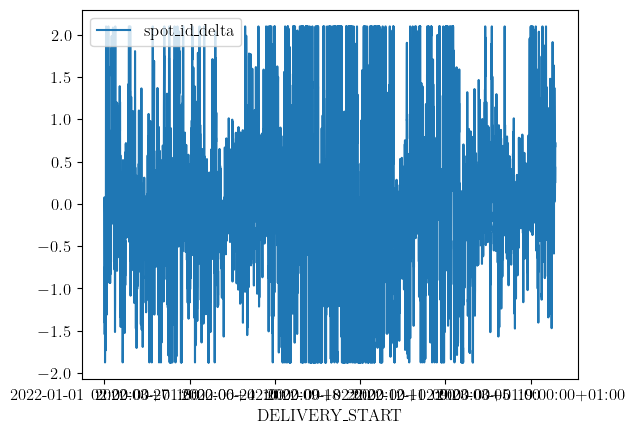

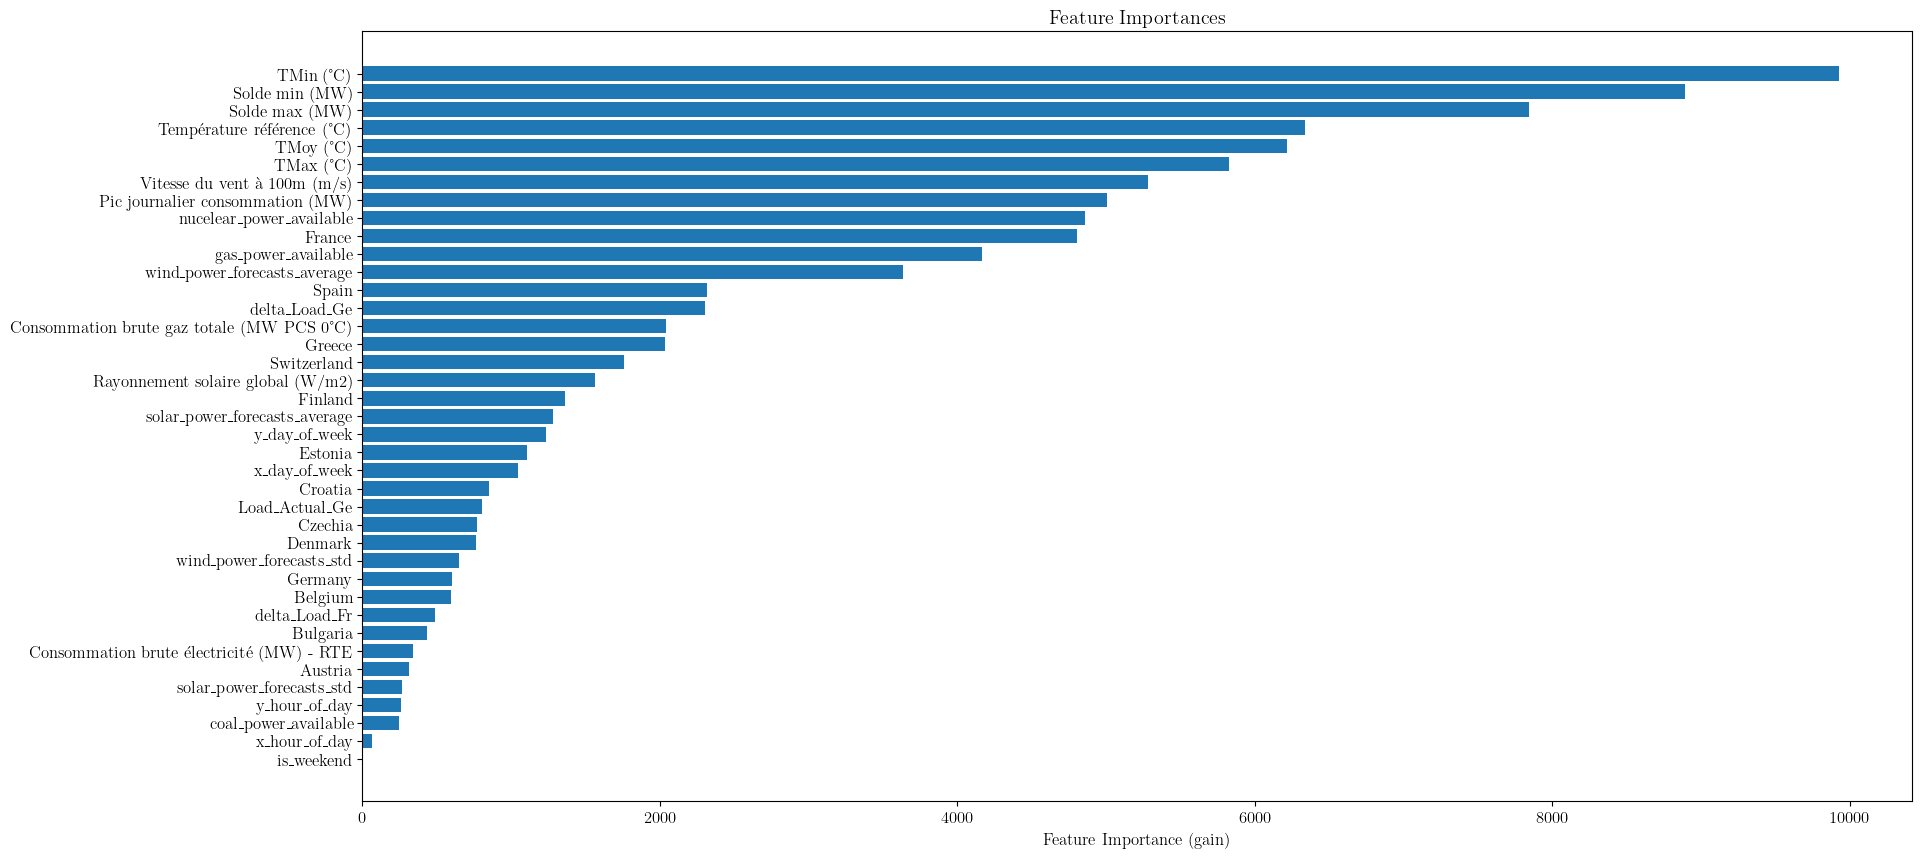

In [96]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train_raw.plot()
print(f"[before scaling/clipping y_train_raw] Class -1: {np.mean(np.sign(y_train_raw)==-1):.3f} | Class 1: {np.mean(np.sign(y_train_raw)==1):.3f}")
y_train_raw, scaled_threshold = scale_target(y_train_raw, 'RobustScaler')
y_train_raw = clip_target(y_train_raw, clip_percentile)
y_pred_binary_train_raw = custom_sign(y_train_raw, thr=scaled_threshold)
print(f"[after scaling/clipping y_train_raw] Class -1: {np.mean(y_pred_binary_train_raw==-1):.3f} | Class 1: {np.mean(y_pred_binary_train_raw==1):.3f}")
y_train_raw.plot()

if random_y_val:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_raw, test_size=test_size, random_state=42)
else:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_raw, test_size=test_size, shuffle=False)

y_train_binary = custom_sign(y_train, thr=scaled_threshold)
y_val_binary = custom_sign(y_val, thr=scaled_threshold)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

model = lgb.train(parameters, lgb_train, valid_sets=lgb_eval, num_boost_round=num_boost_round)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

y_pred_binary_train = custom_sign(y_pred_train, thr=scaled_threshold)
y_pred_binary_val = custom_sign(y_pred_val, thr=scaled_threshold)
y_pred_binary_test = custom_sign(y_pred_test, thr=scaled_threshold)
corrected_y_pred_binary_test = threshold_percentile(y_pred_test, correction_percentile)

print(f"Training Accuracy: {accuracy_score(y_train_binary, y_pred_binary_train):.3f} | Class -1: {np.mean(y_pred_binary_train==-1):.3f} | Class 1: {np.mean(y_pred_binary_train==1):.3f}")
print("Training Confusion Matrix: \n", confusion_matrix(y_train_binary, y_pred_binary_train))
y_train_raw = Elmy_import('../data/raw/y_train_raw.csv', with_date=False)
weights_train = y_train_raw.loc[train_index].iloc[:-int(len(train_index) * test_size)-1, 0].abs().values
weights_val = y_train_raw.loc[train_index].iloc[-1-int(len(train_index) * test_size):, 0].abs().values
for c_percentile in c_percentiles:
    ypbt = threshold_percentile(y_pred_train, c_percentile)
    print(f"Training Accuracy ({c_percentile}-percentile): {accuracy_score(y_train_binary, ypbt):.3f} | Class -1: {np.mean(ypbt==-1):.3f} | Class 1: {np.mean(ypbt==1):.3f}")
    print(f"Weighted accuracy: {weighted_accuracy_score(y_train_binary[:, 0], ypbt, weights_train)}")
    
print(f"Validation Accuracy: {accuracy_score(y_val_binary, y_pred_binary_val):.3f} | Class -1: {np.mean(y_pred_binary_val==-1):.3f} | Class 1: {np.mean(y_pred_binary_val==1):.3f}")
print("Validation Confusion Matrix: \n", confusion_matrix(y_val_binary, y_pred_binary_val))
for c_percentile in c_percentiles:
    ypbv = threshold_percentile(y_pred_val, c_percentile)
    print(f"Validation Accuracy ({c_percentile}-percentile): {accuracy_score(y_val_binary, ypbv):.3f} | Class -1: {np.mean(ypbv==-1):.3f} | Class 1: {np.mean(ypbv==1):.3f}")
    print(f"Weighted accuracy: {weighted_accuracy_score(y_val_binary[:, 0], ypbv, weights_val)}")

if show_feature_importance:
    # Feature importance
    feature_importance = model.feature_importance(importance_type='gain')
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_features = np.array(final_features)[sorted_indices]
    sorted_importance = feature_importance[sorted_indices]

    # Plot feature importances
    plt.figure(figsize=(20, 10))
    plt.barh(range(len(sorted_features)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('Feature Importance (gain)')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig('Feature_importance_lgb.pdf', format='pdf')
    plt.show()
    

In [ ]:
len(y_train_binary), len(ypbt), len(weights_train)

(7934, 7934, 7935)

In [76]:
len(y_val_binary), len(weights_val)

(2645, 2644)

In [80]:
y_train_binary.shape, ypbt.shape, weights_train.shape

((7934, 1), (7934,), (7934,))

In [ ]:
to_save = [None, 'orginal', f'{correction_percentile}_corrected'][-1]
save_true = True

In [14]:
if not os.path.exists('../data/submission'):
    os.makedirs('../data/submission')
y_random_raw = Elmy_import('../data/raw/y_test_random.csv', with_date=False)
print(f"Class 0: {np.mean(y_pred_binary_test==-1):.3f} | Class 1: {np.mean(y_pred_binary_test==1):.3f}")
print(f"(corrected {correction_percentile}-percentile) Class 0: {np.mean(corrected_y_pred_binary_test==-1):.3f} | Class 1: {np.mean(corrected_y_pred_binary_test==1):.3f}")
if to_save is not None:
    if 'original' in to_save:
        submission = pd.DataFrame(y_pred_binary_test, columns=y_random_raw.columns, index=y_random_raw.index)
    elif 'corrected' in to_save:
        submission = pd.DataFrame(corrected_y_pred_binary_test, columns=y_random_raw.columns, index=y_random_raw.index)
    save_path = f'../data/submission/y_lbg_reg_new_features_noe_{to_save}.csv'
    submission.to_csv(save_path)
    print(f"Successfully saved a submission at path: {save_path}")
if save_true:
    submission = pd.DataFrame(np.array(y_pred_test), columns=y_random_raw.columns, index=y_random_raw.index)
    save_path = f'../data/submission/true_lbg_reg_new_features_noe_{to_save}.csv'
    submission.to_csv(save_path)
    print(f"Successfully saved a submission at path: {save_path}")

Class 0: 0.590 | Class 1: 0.410
(corrected 70-percentile) Class 0: 0.300 | Class 1: 0.700
Successfully saved a submission at path: ../data/submission/y_lbg_reg_new_features_noe_70_corrected.csv
Successfully saved a submission at path: ../data/submission/true_lbg_reg_new_features_noe_70_corrected.csv


In [3]:
X_train = Elmy_import('../data/processed/X_train.csv', with_date=False)